In [1]:
suppressMessages(library(car))
suppressMessages(library(effects))
suppressMessages(library(emmeans))

# Follow-up Tests
In our previous lesson, we ran through all the main steps needed the fit and interpet an ANOVA, using the linear models framework. Unfortunately, this may still not have told us everything we wanted to know about our data. Although we began by justifying omnbius tests on the grounds of multiple comparisons, if an omnibus tests points towards an interesting effect we still want to know exactly *which* means are driving it. This is the realm of *follow-up tests*, which will be our focus in this section and which will complete the steps needed for a complete ANOVA-style analysis.

## Motivating Example
To start with, let us see an example of the situation where follow-up tests are desired. To do so, we will follow the typical analysis steps of:

1. Fitting the model using `lm()`
2. Checking and dealing with all the assumptions to our satisfaction
3. Calling `summary()` on the model and interpreting the output 
4. Calling `Anova()` on the model and interpreting the output

As an example, we will use the same full-factorial model of `mtcars` from last week. However, we will increase the complexity by including the `origin` variable with *three* levels (`Japan`, `USA` and `Europe`). So, we now have a $2 \times 3$ ANOVA model and our means table is

|                     | Origin: Europe   |  Origin: Japan  | Origin: USA   | 
|---------------------|------------------|-----------------| --------------|
| **Shape: Straight** | Europe, Straight | Japan, Straight | USA, Straight | 
| **Shape: V-shaped** | Europe, V-shaped | Japan, V-shaped | USA, V-shaped | 

To make this example more useful, we will again engineer a fake interaction by increasing the value of MPG for the `(Japan, V-Shaped)` cell alone. The code for this is given in the drop-down below, if you are curious.

In [2]:
data(mtcars)

# Origin factor
mtcars$origin <- c('Japan','Japan','USA','USA','USA','USA','USA','Europe','Europe',
                   'Europe','Europe','Europe','Europe','Europe','USA','USA','USA',
                   'Europe','Japan','Japan','Japan','USA','USA','USA','USA',
                   'Europe','Europe','Europe','USA','Europe','Europe','Europe')
mtcars$origin <- as.factor(mtcars$origin)

# VS factor
vs.lab <- rep("",length(mtcars$vs)) 
vs.lab[mtcars$vs == 0] <- "V-shaped"
vs.lab[mtcars$vs == 1] <- "Straight"
mtcars$vs <- as.factor(vs.lab)

# Create fake interaction
mpg.fake          <- mtcars$mpg                  # copy mpg
mpg.idx           <- mtcars$origin == "Japan" &
                     mtcars$vs     == "V-shaped" # index of Japan-VShaped cell
mpg.fake[mpg.idx] <- mpg.fake[mpg.idx] + 15      # add constant to all data from that cell
mtcars$mpg.fake   <- mpg.fake   

The modelling steps are therefore


Call:
lm(formula = mpg.fake ~ origin + vs + origin:vs, data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-7.100 -2.766 -0.025  1.858  7.938 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             24.4625     1.4671  16.674 2.11e-15 ***
originJapan              4.1375     2.8093   1.473  0.15281    
originUSA               -3.6958     2.8093  -1.316  0.19980    
vsV-shaped              -6.1958     2.2411  -2.765  0.01034 *  
originJapan:vsV-shaped  13.5958     4.4013   3.089  0.00474 ** 
originUSA:vsV-shaped     0.1792     3.5333   0.051  0.95995    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.15 on 26 degrees of freedom
Multiple R-squared:  0.7206,	Adjusted R-squared:  0.6669 
F-statistic: 13.41 on 5 and 26 DF,  p-value: 1.629e-06

Anova Table (Type II tests)

Response: mpg.fake
          Sum Sq Df F value    Pr(>F)    
origin    663.27  2 19.2594 7.391e-06 ***
vs         99

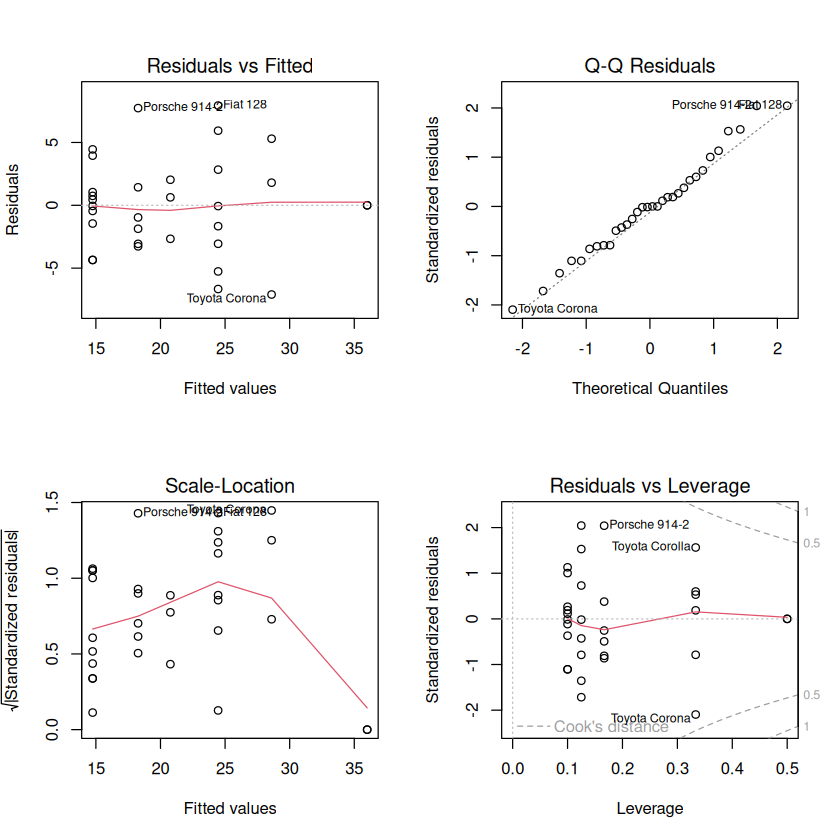

In [3]:
# 1. Fit full factorial model
mod <- lm(mpg.fake ~ origin + vs + origin:vs, data=mtcars)

# 2. Check assumptions
par(mfrow=c(2,2)); plot(mod)

# 3. Call summary() on the final model
print(summary(mod))

# 4. Generate ANOVA table
print(Anova(mod))

For the sake of simplicity, we will skip any rounds of transformation or further assumptions checking. So, just based on this output, what can be conclude?

Looking at the ANOVA table, and sticking with NHST for ease, we can see a significant omnibus interaction effect ($F_{2,26} = 5.27, p < 0.05$). As these are Type II tests, we need to ignore the main effects and just work on understanding the interaction. Conceptually, we can think of this effect as indicating that the difference in MPG between `Straight` and `V-Shaped` depends upon whether the car came from `Japan`, `USA` or `Europe`[^interact-foot].

So, we are now at the point that we ended on last week. However, it seems we still have some unanswered questions. Because the interaction is an *omnibus* test, it does not tell us *which* differences are driving the effect. We can conclude that the country of origin appears to change how MPG differs between the two engine shapes, but surely we want to know *how* this actually occurs? Which countries show the largest difference? Are there any countries where the engine shape makes little difference to MPG? Is this effect driven only by one country or are there multiple countries?

We could get some of the way towards answering these questions by simply *plotting* the effects. In general, this should always be a first priority after finding any significant effects. So let us have a look at the interaction using an effects plot

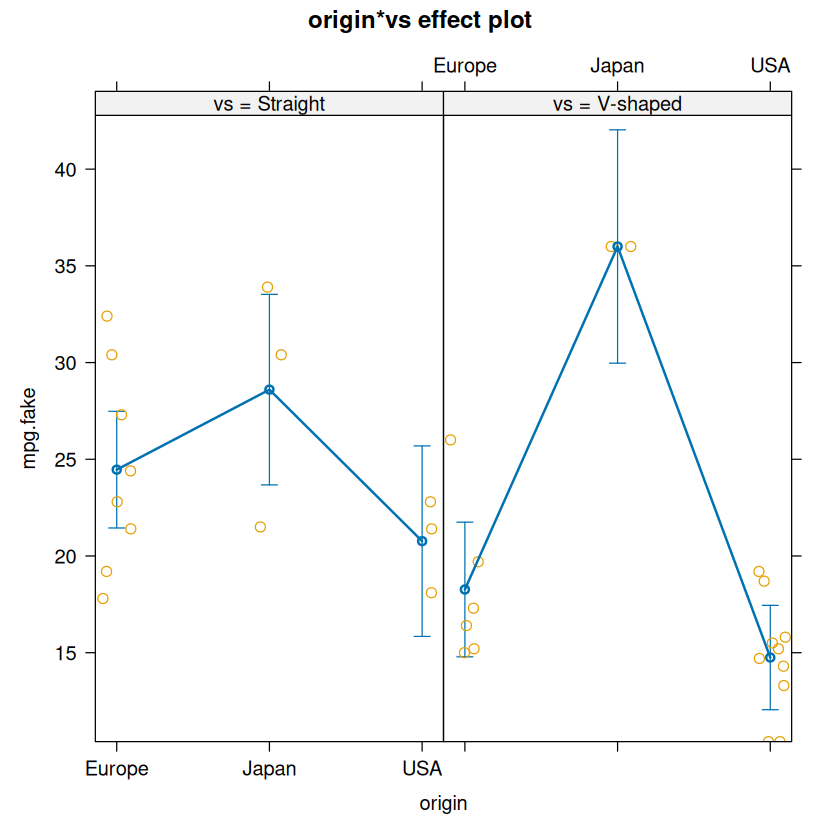

In [4]:
plot(effect("origin:vs", mod, residuals=TRUE), partial.residuals=list(smooth=FALSE))

We can clearly see that there is a much larger difference between `Straight` and `V-Shaped` for `Japan` compared to either `Europe` or `USA`. However, we cannot tell whether the differences for either `Europe` or `USA` are meaningful. This is important because it implies that there is something about Japanese manufacturing and engineering that makes V-shaped engines more efficient[^fake-foot]. However, we cannot tell whether V-shaped engines in `Europe` and `USA` are actually *less efficient*, or have practically the *same* efficiency as straight engines. The only way to get that information is to perform some *follow-up tests*.

`````{admonition} Follow-up tests, post-hoc tests and planned comparisons
:class: tip
As with many elements of statistics, comparisons that we run after the omnibus ANOVA tests have some different names with some subtle interpretational differences. In general, any test performed in an effort to unpack the ANOVA omnibus test is regarded as a *follow-up test*, because it follows the main ANOVA analysis. This is clearly unnecessary if the omnibus test only involves 2 means, so these tests are really for *main effects* of factors with $k > 2$ levels and for interactions. In some instances, this may necessitate further omnibus tests to break down a larger omnibus test. So the core distinction in terminology is not related to the form of the tests, but rather their *intent*. This is the difference between *post-hoc tests* and *planned comparisons*. Post-hoc tests are those where we have found a significant effect and then wish to break it down to find out what is driving it. Planned comparisons are those tests that we decided on *before* running the analysis. For instance, if we had a clinical trial then the only differences we might care about are those between the patients and controls. There are arguments around error control and the type of follow-up test we are using, but we will discuss those further below. For now, the main practical difference is that planned comparisons can make omnibus tests *redundant*. So, if you only have a small number of comparisons you want to make, you can probably skip the omnibus tests entirely and just go straight to those comparisons of interest.
``````

## Using the Regression Tests
One of the most obvious ways we could try to break-down an omnibus ANOVA effect is by returning to the tests of the parameter estimates from the regression model. In simple cases, this is a perfectly fine thing to do. For instance, in a one-way ANOVA, these tests cover all the differences we are interested in (potentially after a few rounds of re-leveling the factor). In the case of *planned comparisons*, if we can engineer the dummy variables to represent all the comparisons we care about, then we do not even need the ANOVA table. For example, setting the control group as the *reference level* could achieve this. In these cases, we can simply work with the results of `summary()` and our job is done[^regmc-foot]. 

The problems arrive in more complex models, as the model parameters do not necessarily correspond to effects we are interested in. To see this, let us return to $2 \times 3$ model above and examine how the factors are coded.

In [5]:
print(contrasts(mtcars$origin))
print(contrasts(mtcars$vs))

       Japan USA
Europe     0   0
Japan      1   0
USA        0   1
         V-shaped
Straight        0
V-shaped        1


Given this, the full combination of dummy variables in this model would be[^modmat-foot]

In [6]:
X <- matrix(c(1,0,0,0,
              1,0,0,1,
              1,1,0,0,
              1,1,0,1,
              1,0,1,0,
              1,0,1,1), nrow=6, byrow=TRUE)

# interaction columns from multiplying the main effect dummy variables
interact.1 <- X[,2] * X[,4] 
interact.2 <- X[,3] * X[,4]

# add the interaction columns on
X <- cbind(X,interact.1,interact.2)

rownames(X) <- c("Europe Straight", "Europe V-Shaped",
                  "Japan Straight", "Japan V-Shaped",
                  "USA Straight", "USA V-Shaped")

colnames(X) <- c("beta.0","beta.1","beta.2","beta.3","beta.4","beta.5")
colnames(X) <- c("(Intercept)","Japan","USA","V-shaped","Japan:V-shaped","USA:V-shaped") # names from lm(), if you prefer
print(X)


                (Intercept) Japan USA V-shaped Japan:V-shaped USA:V-shaped
Europe Straight           1     0   0        0              0            0
Europe V-Shaped           1     0   0        1              0            0
Japan Straight            1     1   0        0              0            0
Japan V-Shaped            1     1   0        1              1            0
USA Straight              1     0   1        0              0            0
USA V-Shaped              1     0   1        1              0            1


Where the final two interaction columns comes from multiplying the columns for `origin` and the columns for `vs`. Remember, each row of weights tells us the precise combination of parameters we need for each cell mean. For example, the row that corresponds to `(Japan, V-Shaped)` tells us that this cell mean is equal to

$$
\begin{alignat*}{1}
    \mu_{(\text{JAP,V})} &= (\beta_{0} \times \mathbf{1}) + (\beta_{1} \times \mathbf{1}) + (\beta_{2} \times \mathbf{0}) + (\beta_{3} \times \mathbf{1}) + (\beta_{4} \times \mathbf{1}) + (\beta_{5} \times \mathbf{0}) \\
    &= \beta_{0} + \beta_{1} + \beta_{3} + \beta_{4}
\end{alignat*}
$$

This matrix of weights is therefore the *key* that unlocks the meaning of the parameter estimates and thus the meaning of the automatic tests. Remember, there is no sense in which the model has to be *meaningful* here. All that is necessary is that a unique solution to the model parameters can be found. So, based on this, we can work out what each parameter in the model means and can decide whether any of these numbers actually answer our questions. If they do, we can use the associated $t$-tests. If they do not, we need to find another approach. 

The interpretations of the parameters associated with the constant and main effects can be derive by looking at the weights above and seeing which cells are coded either by the intercept alone, or the intercept *plus* one other parameter. This leads to

|  Parameter  | Name in `R`   | Meaning                                 | 
|-------------|---------------|-----------------------------------------|
| $\beta_{0}$ | `(Intercept)` | `(Europe,Straight)`                     |
| $\beta_{1}$ | `originJapan` | `(Japan,Straight) - (Europe,Straight)`  |
| $\beta_{2}$ | `originUSA`   | `(USA,Straight) - (Europe,Straight)`    |
| $\beta_{3}$ | `vsV-shaped`  | `(Europe,V-shaped) - (Europe,Straight)` |

The interaction parameters are trickier and need more explanation. Remember, the main reason for going into this detail is to indicate why we do not typically use the regression parameters for follow-up tests. The intention is *not* that you would go through this process of working out what the parameters mean for every single model. Indeed, this is often difficult and usually unnecessary. For this demonstration, we will follow the logic only to demonstrate why the regression tests are often uninteresting. We will see a much easier approach a little later.

In terms of the first interaction parameter $(\beta_{4})$, we can see from the dummy variables table that this only appears in the definition of the `(Japan, V-Shaped)` cell, as follows

$$
\mu_{(\text{JAP,V})} = \beta_{0} + \beta_{1} + \beta_{3} + \beta_{4}
$$

So, we can solve for $\beta_{4}$ and try and interpret what it means

$$
\beta_{4} = \mu_{(\text{JAP,V})} - (\beta_{0} + \beta_{1} + \beta_{3})
$$

Here we can see that this value is some sort of *difference* between the true cell mean and the value produced by $\beta_{0} + \beta_{1} + \beta_{3}$. Thinking back to our discussion of an *additive* model last week, we can interpret this as our reference cell mean ($\beta_{0}$) plus a constant *column effect* ($\beta_{1}$) plus a constant *row effect* ($\beta_{3}$). If there is no interaction, this combination will equal the cell mean for `(Japan, V-Shaped)`. If there is an interaction, we need to add an additional *offset* to make this value equivalent to the true cell mean. This offset is given by $\beta_{4}$. So, we can interpret this parameter as the *extra* needed to make the constant row and column effects equal the cell mean. If the additive model holds, this will be close to 0. If it does not, this value will be much larger than 0.

The exact same logic holds for $\beta_{5}$, which can be interpreted as

$$
\beta_{5} = \mu_{(\text{USA,V})} - (\beta_{0} + \beta_{2} + \beta_{3})
$$

and the only difference is that the *column effect* ($\beta_{2}$) represents the difference between the reference cell and the USA, rather than the difference between the reference cell and Japan. We can bring all this together in some `R` code, to check our interpretation.

In [7]:
# Generate all 6 cell means from the data
EUR.Str <- mean(mtcars$mpg.fake[mtcars$origin == "Europe" & mtcars$vs == "Straight"])
EUR.V   <- mean(mtcars$mpg.fake[mtcars$origin == "Europe" & mtcars$vs == "V-shaped"])
JAP.Str <- mean(mtcars$mpg.fake[mtcars$origin == "Japan"  & mtcars$vs == "Straight"])
JAP.V   <- mean(mtcars$mpg.fake[mtcars$origin == "Japan"  & mtcars$vs == "V-shaped"])
USA.Str <- mean(mtcars$mpg.fake[mtcars$origin == "USA"    & mtcars$vs == "Straight"])
USA.V   <- mean(mtcars$mpg.fake[mtcars$origin == "USA"    & mtcars$vs == "V-shaped"])

# Manual parameter definitions
beta.0 <- EUR.Str
beta.1 <- JAP.Str - EUR.Str
beta.2 <- USA.Str - EUR.Str
beta.3 <- EUR.V   - EUR.Str
beta.4 <- JAP.V - (beta.0 + beta.1 + beta.3) 
beta.5 <- USA.V - (beta.0 + beta.2 + beta.3) 

# Compare
manual <- c(beta.0,beta.1,beta.2,beta.3,beta.4,beta.5)
beta   <- coef(mod)

print(data.frame("manual"=manual, "model"=beta))

                           manual      model
(Intercept)            24.4625000 24.4625000
originJapan             4.1375000  4.1375000
originUSA              -3.6958333 -3.6958333
vsV-shaped             -6.1958333 -6.1958333
originJapan:vsV-shaped 13.5958333 13.5958333
originUSA:vsV-shaped    0.1791667  0.1791667


So we can see that our interpretation is *correct* and we now know what each parameter means. 

Is it time to celebrate? Well, not really. This took a lot of effort and, unfortuantely, most of these values are not quantities we are interested in. The only one that is close is the estimate for `vsV-shaped`, because this is a test of the effect of `vs` for `Europe` only. However, we also want to know the effects of `vs` for `Japan` and the effect of `vs` for `USA`, both of which are absent. So while we have worked hard to get here, we are not actually any closer to answering our questions about the differences between `straight` and `v-shaped` engines within each country.

`````{admonition} Main point: Do not worry about the regression tests in an ANOVA!
:class: warning
The main point of this demonstration was not to suggest that you should always spend time trying to interpret what the parameter estimates mean in complex ANOVA models. You can, if you want. However, this interpretation always depends on the precise form of dummy coding used, as well as the cell that is coded as the reference. As such, this is a slightly *arbitrary* element of the model. Indeed, what this demonstrates is that you probably should *not* worry about the precise meaning of the parameter estimates, unless the model is very simple. Because of this, you should also not worry about the meaning of the tests of the parameters. It would be tempting to look at the test for the coefficient `vsV-shaped` and think this indicates the main effect of `vs`. Indeed, this is a very common mistake that gets made by researchers. But we now know that it does not. It indicates the effect of `vs` *for European cars only*. This is why we rely on the omnibus tests (because they do not depend upon the coding), but also why we need to find some other method of generating follow-up tests that actually test the comparisons we want.
``````

## Using Linear Contrasts
Given the discussion above, we cannot rely on using the regression tests for all our comparisons of interest. So what can we do? The answer is that, rather than using the individual parameter estimates for our tests, we need to use those parameter estimates to *construct* the tests we are interested in. In the section below, we will show how any comparison we want can be directly derived from the estimates, irrespective of the dummy coding used. However, in practice, we do not need to do this manually. Instead, we can use the package `emmeans` to create these for us automatically. We will start with the manual approach, just so you understand what `emmeans` is doing, but will then see how to use the package to make everything easier.

### Simple Main Effects
Sticking with our significant interaction effect, it is useful to first of all define exactly *what* comparisons we want to make. Although there are multiple options, the most useful way to break-down an interaction is to form what are known as *simple main effects* (sometimes called *simple effects*). These are just comparisons between cell means, holding one of the factors constant. If we go back to our means table

|                     | Origin: Europe   |  Origin: Japan  | Origin: USA   | 
|---------------------|------------------|-----------------| --------------|
| **Shape: Straight** | Europe, Straight | Japan, Straight | USA, Straight | 
| **Shape: V-shaped** | Europe, V-shaped | Japan, V-shaped | USA, V-shaped | 

then in order to break-down the interaction, we could compare the *rows* separately within each column. This would give use the effect of `vs` for each level of `origin`. So we would have:

1. `vs (@ Europe) = (Europe,Straight) - (Europe,V-shaped)`
2. `vs (@ Japan)  = (Japan,Straight)  - (Japan,V-shaped)`
3. `vs (@ USA)    = (USA,Straight)    - (USA,V-shaped)`

So there are 3 simple main effects we can calculate. If there is no interaction these will all be very similar, reflecting a *constant row effect*. If there is an interaction these will be different, reflecting a row effect that *changes* depending upon the column. For the purpose of illustration, we will show how to go the value of just *one* of these simple main effect. Remember, you will almost *never* need to actually do this manually. However, it can be very useful to understand *how* this works before we automate all the theory away. 

For our example, let us work on the difference `(Japan,Straight) - (Japan,V-shaped)` (simple effect number 2) To do this, we need to go back to the dummy variables from earlier and find the row that codes for `(Japan,Straight)` and the row that codes for `(Japan,V-shaped)`. We will save these weights to two new variables.

In [8]:
JAP.Str <- c(1,1,0,0,0,0)
JAP.V   <- c(1,1,0,1,1,0)

Remember, these weights tells us that

$$
\begin{alignat*}{1}
    \mu_{(\text{JAP,Str})} &= \beta_{0} + \beta_{1} \\
    \mu_{(\text{JAP,V})}   &= \beta_{0} + \beta_{1} + \beta_{3} + \beta_{4}. 
\end{alignat*}
$$

So how do we find the difference? We simply subtract the weights.

In [9]:
print(JAP.Str - JAP.V)

[1]  0  0  0 -1 -1  0


This tells us what combination of parameters will give us the *difference* `(Japan,Straight) - (Japan,V-shaped)`. In this case, the resultant weights tell us that

$$
\begin{alignat*}{1}
\mu_{(\text{JAP,Str})} - \mu_{(\text{JAP,V})} &= (\beta_{0} \times \mathbf{0}) + (\beta_{1} \times \mathbf{0}) + (\beta_{2} \times \mathbf{0}) + (\beta_{3} \times \mathbf{-1}) + (\beta_{4} \times \mathbf{-1}) + (\beta_{5} \times \mathbf{0}) \\
&= -\beta_{3} + (-\beta_{4})
\end{alignat*}
$$

We can see this below in code

In [10]:
b <- coef(mod)
c  <- (b[1]* 0) + (b[2]* 0) + (b[3]*0) + (b[4]*-1) + (b[5]*-1) + (b[6]*0)
print(unname(c))

[1] -7.4


This is known as a *linear contrast* of the parameter estimates. 

Although this may seem a rather complicated way of simply subtracting two cell means, the utility of doing it this way is twofold. Firstly, it is incredibly flexible because we can use any weights we like to derive a wide variety of quantities that answer different questions about the model. If we start with the coding of each cell mean, we can then combine and compare the cell means in any way we choose and derive the weights needed to recover that value from the parameter estimates. Secondly, and perhaps most importantly, the weights that code the comparison can also be used to find the *standard error* of the comparisons and thus form a test statistic. This gets a little more complex and so we will not dwell on the details. However, we can show this works using a function that we have written called `contrast.se()` (defined in the drop-down below). Passing this the contrast weights and the model will produce the standard error of the comparison defined by the weights

In [11]:
contrast.se <- function(weights, mod){
    L <- as.matrix(weights)
    if (nrow(L) == 1){
        L <- t(L)
    }
    V  <- vcov(mod)
    se <- sqrt(t(L) %*% V %*% L)
    return(se)
}

In [12]:
weights <- JAP.Str - JAP.V
con.se  <- contrast.se(weights,mod)
print(con.se)

         [,1]
[1,] 3.788071


The point of this is to show that we now have a way of defining a test statistic for this comparison, as $t = \frac{-7.4}{3.79}$. So we can now also generate a $p$-value. In general, this means we can derive a hypothesis test for *any comparison between the cell means*, so long as we know the weights. For instance, if we wanted to compare the mean `(Japan,Straight)` to the *average* of `(Europe,Straight)` and `(USA,Straight)` we could do

In [13]:
JAP.Str <- c(1,1,0,0,0,0)
EUR.Str <- c(1,0,0,0,0,0)
USA.Str <- c(1,0,1,0,0,0)

W   <- JAP.Str - mean(EUR.Str + USA.Str)             # Weights
Con <- (b[1]*W[1]) + (b[2]*W[2]) + (b[3]*W[3]) + 
       (b[4]*W[4]) + (b[5]*W[5]) + (b[6]*W[6])       # Contrast
SE  <- contrast.se(W,mod)                            # Standard error
t   <- Con/SE                                        # t-statistic
p   <- 2*pt(t, df=mod$df.residual, lower.tail=FALSE) # p-value

results <- data.frame("Contrast"=Con, "Se"=SE, "t"=t, "p"=p)
print(results, row.names=FALSE)

 Contrast       Se        t            p
 12.35833 3.006688 4.110281 0.0003504753


This is a very powerful framework, however, it is fiddly to use because we have to derive the weights that code the cell means (and make sure we have done this correctly) and then need to derive the weights for the comparisons from those weights, and then calculate the effect and the standard error manually. So, in order to automate all of this for us, we can use the `emmeans` package.

### The `emmeans` Package
Thankfully, all the hassle of deriving weights for the comparisons we want is unnecessary because we can automate this procedure using the `emmeans` package. This is a very powerful piece of software that contains a myriad of useful functions for performing follow-up tests. The name itself stands for `e`stimated `m`arginal `means`, which highlights that it aims to produce tests based on the means estimated from the model. This is important, because depending upon the model and its complexity, these estimated means may not always be the same as the sample means. Further more, the most suitable error term for any tests can only be derived from the model itself. As such, it is important that we are able to extract what the model has estimated and conduct our comparisons based on that, rather than just simply performing some $t$-tests or another ANOVA on data that we have manually separated into different cells[^followup-foot]. This is the only accurate way of breaking the effects from a model down.

To see the most basic way of using the `emmeans` package, we will demonstrate the use of the `emmeans()` function. As an argument, it first takes the model we are working on and then takes a formula argument. The formula can use the keyword `pairwise` to indicate that we want to perform pairwise comparisons between all levels of the named factor. For instance, `pairwise ~ vs` would give us tests between all the levels of `vs`. Similarly, `pairwise ~ origin` would give us tests between all the levels of `origin`. Importantly, we can also provide a vertical bar symbol `|` to indicate that we want to perform all those comparisons *at each level* of another factor. This has a nice connection with the mathematical notation for some value being *conditional* on another. So, we can use `pairwise ~ vs|origin` and get pairwise tests of the levels of `vs` at each level of `origin`. We can see this below.

In [14]:
library(emmeans)
emm <- emmeans(mod, pairwise ~ vs|origin)
print(emm$contrasts)


origin = Europe:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)     6.20 2.24 26   2.765  0.0103

origin = Japan:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)    -7.40 3.79 26  -1.954  0.0616

origin = USA:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)     6.02 2.73 26   2.203  0.0367



So, we can actually see that despite our intuition from the earlier plot, the effect of `vs` for `Japan` is actually *non-significant*, whereas the effects for both `Europe` and `USA` *are* significant. We can also see that the test for `origin = Europe` is the same as the test for $\beta_{3}$ in the regression output, further confirming our interpetation of the parameters.

Of interest is that we can use the `linfct()` function on the object returned by `emmeans()` to show the contrast weights for each of these comparisons. For this current example, we have 

In [15]:
con.weights <- linfct(emm)
print(con.weights$contrasts)

     (Intercept) originJapan originUSA vsV-shaped originJapan:vsV-shaped
[1,]           0           0         0         -1                      0
[2,]           0           0         0         -1                     -1
[3,]           0           0         0         -1                      0
     originUSA:vsV-shaped
[1,]                    0
[2,]                    0
[3,]                   -1


where we can see that the *second* row corresponds to the weights we derived for `(Japan,Straight) - (Japan,V-shaped)`, the *first* row just returns the parameter associated with `vsV-shaped`[^neg-foot] and the final row gives the weights for `(USA,Straight) - (USA,V-shaped)`. As such, we can see that `emmeans` is doing *exactly* what we demonstrated manually above, just in an easier and more automated fashion.

### Higher-order interactions

`emmeans(mod, ~ vs:origin|other)`, `emmeans(mod, pairwise ~ vs|origin,other)`??? `emmeans(mod, pairwise ~ vs|origin:other)` ???

## Multiple Comparisons Correction
As the final section in this part of the lesson, we need to take a moment to consider the topic of follow-up tests and multiple comparisons. In the previous lesson, we justified the use of omnibus tests as a guard against the multiple testing problem. Even though this guard exists at a higher-level, when we use the omnibus tests to guide the follow-up tests we still run the risk of false positives. As such, it is customary to apply some degree of correction to the follow-up tests.

### Corrections in `R`

General access to $p$-values corrections is available in base `R` using the `p.adjust()` function. We simply supply a list of $p$-values and the name of the method we want to use and `R` will return the adjusted values. For instance

In [18]:
p.raw <- c(0.002, 0.765, 0.05, 0.123)
p.adj <- p.adjust(p=p.raw, method="bonferroni")

print(p.adj)

[1] 0.008 1.000 0.200 0.492


In this example, the basic Bonferroni method is used where each $p$-value is multiplied by the number of $p$-values. We can see this for ourseleves by calculating this correction manually.

In [19]:
# bonferroni correction
n.p   <- length(p.raw)
p.adj <- p.raw * n.p 

# make sure all p <= 1
for (i in 1:n.p){
    if (p.adj[i] > 1){
        p.adj[i] <- 1
    }
}

print(p.adj)

[1] 0.008 1.000 0.200 0.492


In terms of other adjustment methods, `R` has 6 built-in possibilities that can be listed by calling `p.adjust.methods`

In [20]:
print(p.adjust.methods)

[1] "holm"       "hochberg"   "hommel"     "bonferroni" "BH"        
[6] "BY"         "fdr"        "none"      


noting that `fdr` is an alias for `BH`, and `none` is just a pass-through option that does nothing. It is somewhat beyond this lesson to go into the details of all of these. So, a very general heuristic is to use the `holm` method as the most general-purpose approach. This is more powerful than `bonferroni`[^bonf-foot], but has no additional assumptions. If the $p$-values are *correlated* (e.g. from repeated measurements), then `hochberg` is a better choice because it relaxes the assumption of independance yet retains good power.  

### Corrections and Families of Tests in `emmeans`
In terms of using these corrections within `emmeans`, it is a simple as using the `adjust` argument to name the correction that we want applied. As an example, using the `holm` method with the follow-up tests of the `vs:origin` interaction gives.

In [21]:
emm <- emmeans(mod, pairwise ~ vs|origin, adjust="holm")
print(emm$contrasts)

origin = Europe:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)     6.20 2.24 26   2.765  0.0103

origin = Japan:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)    -7.40 3.79 26  -1.954  0.0616

origin = USA:
 contrast              estimate   SE df t.ratio p.value
 Straight - (V-shaped)     6.02 2.73 26   2.203  0.0367



Now, you would be forgiven for thinking that nothing has changed here. And, in fact, you would be right. In this instance, `emmeans` has not applied any correction, despite our request. So what is going on?

The answer is that concept of multiple comparisons is not always as straightforward as it might seem. ...


... Each level of the second factor is taken to define a family of tests, independent from other levels. We can see this if we swap the tests defined earlier to look at the effects of `origin` at each level of `vs`

In [22]:
emm <- emmeans(mod, pairwise ~ origin|vs, adjust="holm")
print(emm$contrasts)

vs = Straight:
 contrast       estimate   SE df t.ratio p.value
 Europe - Japan    -4.14 2.81 26  -1.473  0.3056
 Europe - USA       3.70 2.81 26   1.316  0.3056
 Japan - USA        7.83 3.39 26   2.312  0.0869

vs = V-shaped:
 contrast       estimate   SE df t.ratio p.value
 Europe - Japan   -17.73 3.39 26  -5.234  <.0001
 Europe - USA       3.52 2.14 26   1.641  0.1128
 Japan - USA       21.25 3.21 26   6.611  <.0001

P value adjustment: holm method for 3 tests 


So, `emmeans` takes this as two families, each containing 3 tests. Corrections to the $p$-values are then applied *within* families.

### Planned Comparisons vs Post-hoc Tests
... Beware of this reasoning. Although planned tests are more *credible* in the sense that you are not $p$-hacking, this does not change anything about the error rate. The error does not magically know what your intentions were and then change itself. The error rate is a fact of multiple testing that does not change with intent. As such, even if you have pre-specified tests, you still need to control for multiple comparisons.

[^fake-foot]: Remember, these data are *entirely* fabricated. There is nothing magical about Japanese cars that makes V-shaped engines super efficient in terms of MPG.

[^modmat-foot]: You do not need to construct these weights manually, as shown in the code. Instead, you can get the coding for the *whole* model by using the `model.matrix()` function and passing in the model object. This will show you the *exact* coding for every data point in the model.

[^cohen-foot]: Cohen's aim was to get practitioners away from $p$-values and the dichotomisation of evidence. So, instead, he decided to *trichotomise* his measure of effect size into *Small = 0.2*, *Medium = 0.5* and *Large = 0.8*. In Cohen's defence, this was likely a compromise position to try and get his effect size adopted by researchers who do not like subtlety and nuance in their results and would rather just have rules to follow. This is something you will come up against time and time again in the wider world of research.

[^neg-foot]: The fact that this is `-1` rather than `1` makes no differences. It just reverses the direction of the comparison.

[^followup-foot]: This is the approach often advocated in Psychology to follow-up an ANOVA, but it is far from the most appropriate.

[^bonf-foot]: Bonferroni is a very common correction where each $p$-value is multiplied by the number of tests.

[^interact-foot]: Alternatively, we can think of this as indicating that the differences in MPG betwee `Japan`, `USA` and `Europe` depends upon whether the engine is `Straight` or `V-Shaped`. Although interactions can be interpreted different ways around, for most problems there is usually one way of conceptualising the interaction that is more intuitive or useful than the other.

[^regmc-foot]: Though we should be aware that the regression tests are not corrected for multiple comparisons.